In [ ]:
# ================== Imports ==================
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import models, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights, efficientnet_b0, EfficientNet_B0_Weights

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("⚙️  Appareil utilisé :", device)

⚙️  Appareil utilisé : cuda


In [2]:
# ================== Configuration ==================
class Config:
    # Images
    img_size_global = 224
    img_size_local = 96
    patch_size = 96
    num_patches = 4

    # Modèle
    embed_dim = 384
    dropout = 0.5

    # Entraînement
    lr = 5e-5
    weight_decay = 0.05
    batch_size = 8  # Réduire à 8 si problème mémoire
    epochs = 20

    # Régularisation
    use_mixup = True
    mixup_alpha = 0.2
    label_smoothing = 0.1
    early_stopping_patience = 7
    warmup_epochs = 3

    # Features avancées
    use_smart_patches = True  # Extraction intelligente
    use_attention = True       # Mécanismes d'attention

# Chemins
TRAIN_DIR = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\train"
VAL_DIR = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\val"
TEST_DIR = r"C:\Users\ENNHILI YASSINE\Desktop\ASMAE-ABDELOUAFI\test"

print("📁 Vérification des chemins...")
print("TRAIN:", os.path.exists(TRAIN_DIR))
print("VAL:", os.path.exists(VAL_DIR))
print("TEST:", os.path.exists(TEST_DIR))

📁 Vérification des chemins...
TRAIN: True
VAL: True
TEST: True


In [3]:
# ================== Transformations ==================
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(Config.img_size_global, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((Config.img_size_global, Config.img_size_global)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    local_transform = transforms.Compose([
        transforms.Resize((Config.img_size_local, Config.img_size_local)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    return train_transform, val_transform, local_transform

transform_global_train, transform_global_val, transform_local = get_transforms()

In [4]:
# ================== Extraction Intelligente de Patches ==================
class SmartPatchExtractor:
    """Extrait des patches en ciblant les zones avec plus de texture"""
    def __init__(self, patch_size=96, num_patches=4):
        self.patch_size = patch_size
        self.num_patches = num_patches

    def extract_patches(self, pil_img):
        img_array = np.array(pil_img)
        h, w = img_array.shape[:2]
        ps = self.patch_size

        # Calculer variance locale
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

        if h < ps * 2 or w < ps * 2:
            pil_img = pil_img.resize((ps * 3, ps * 3))
            img_array = np.array(pil_img)
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            h, w = img_array.shape[:2]

        grid_h = max(2, h // ps)
        grid_w = max(2, w // ps)

        scores = []
        positions = []

        for i in range(grid_h):
            for j in range(grid_w):
                y_start = i * ps
                x_start = j * ps
                y_end = min(y_start + ps, h)
                x_end = min(x_start + ps, w)

                if y_end - y_start == ps and x_end - x_start == ps:
                    region = gray[y_start:y_end, x_start:x_end]
                    variance = np.var(region)
                    scores.append(variance)
                    positions.append((x_start, y_start))

        if len(scores) >= self.num_patches:
            top_indices = np.argsort(scores)[-self.num_patches:]
            selected_positions = [positions[i] for i in top_indices]
        else:
            selected_positions = positions
            while len(selected_positions) < self.num_patches:
                x = np.random.randint(0, max(1, w - ps))
                y = np.random.randint(0, max(1, h - ps))
                selected_positions.append((x, y))

        patches = []
        for x, y in selected_positions:
            patch = pil_img.crop((x, y, x + ps, y + ps))
            patches.append(patch)

        return patches

In [5]:
# ================== Dataset Amélioré ==================
class SmartLeafDataset(Dataset):
    def __init__(self, root_dir, transform_global, transform_local,
                 num_patches=4, patch_size=96, use_smart_patches=True):
        self.root_dir = root_dir
        self.transform_global = transform_global
        self.transform_local = transform_local
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.use_smart_patches = use_smart_patches

        if use_smart_patches:
            self.patch_extractor = SmartPatchExtractor(patch_size, num_patches)

        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, fname), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def _extract_random_patches(self, pil_img):
        w, h = pil_img.size
        ps = self.patch_size
        patches = []

        if w < ps or h < ps:
            pil_img = pil_img.resize((max(w, ps), max(h, ps)))
            w, h = pil_img.size

        for _ in range(self.num_patches):
            x = np.random.randint(0, max(1, w - ps + 1))
            y = np.random.randint(0, max(1, h - ps + 1))
            patch = pil_img.crop((x, y, min(x + ps, w), min(y + ps, h)))
            if patch.size != (ps, ps):
                patch = patch.resize((ps, ps))
            patches.append(patch)
        return patches

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        img_global = self.transform_global(img)

        if self.use_smart_patches:
            try:
                raw_patches = self.patch_extractor.extract_patches(img)
            except:
                raw_patches = self._extract_random_patches(img)
        else:
            raw_patches = self._extract_random_patches(img)

        local_tensors = [self.transform_local(p) for p in raw_patches]
        patches_tensor = torch.stack(local_tensors, dim=0)

        return img_global, patches_tensor, label

In [6]:
# ================== Mécanismes d'Attention ==================
class PatchAttention(nn.Module):
    """Attention pour pondérer l'importance des patches"""
    def __init__(self, patch_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(patch_dim, patch_dim // 2),
            nn.Tanh(),
            nn.Linear(patch_dim // 2, 1)
        )

    def forward(self, patch_features):
        attn_scores = self.attention(patch_features)
        attn_weights = F.softmax(attn_scores, dim=1)
        weighted_features = patch_features * attn_weights
        aggregated = weighted_features.sum(dim=1)
        return aggregated, attn_weights.squeeze(-1)


class AttentionFusion(nn.Module):
    """Fusion avec attention global vs local"""
    def __init__(self, global_dim, local_dim, hidden_dim=256):
        super().__init__()
        self.global_proj = nn.Linear(global_dim, hidden_dim)
        self.local_proj = nn.Linear(local_dim, hidden_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )

        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, global_feat, local_feat):
        global_h = self.global_proj(global_feat)
        local_h = self.local_proj(local_feat)

        combined = torch.cat([global_h, local_h], dim=1)
        attn_weights = self.attention(combined)

        weighted_global = global_h * attn_weights[:, 0:1]
        weighted_local = local_h * attn_weights[:, 1:2]

        fused_input = torch.cat([weighted_global, weighted_local], dim=1)
        fused = self.fusion(fused_input)

        return fused, attn_weights

In [7]:
# ================== Modèle Complet avec Attention ==================
class AdvancedLocalGlobalNet(nn.Module):
    """Modèle final avec toutes les optimisations"""
    def __init__(self, num_classes, use_attention=True):
        super().__init__()
        self.use_attention = use_attention

        # Branche globale : ViT
        vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        vit_dim = vit.heads.head.in_features
        vit.heads.head = nn.Identity()
        self.vit = vit

        # Branche locale : EfficientNet
        eff = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        eff_dim = eff.classifier[1].in_features
        eff.classifier = nn.Identity()
        self.eff = eff

        if use_attention:
            # Attention sur patches
            self.patch_attention = PatchAttention(eff_dim)
            # Fusion avec attention
            self.attention_fusion = AttentionFusion(vit_dim, eff_dim, hidden_dim=384)
            classifier_input = 384
        else:
            classifier_input = vit_dim + eff_dim

        # Classifier avec forte régularisation
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(classifier_input, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Pour Grad-CAM
        self.global_features = None
        self.local_features = None
        self.fusion_attention_weights = None
        self.patch_attention_weights = None

    def forward(self, img_global, patches_local):
        B, N, C, H, W = patches_local.shape

        # Global
        feat_global = self.vit(img_global)

        # Local
        patches_flat = patches_local.view(B * N, C, H, W)
        feat_local_all = self.eff(patches_flat)
        feat_local_all = feat_local_all.view(B, N, -1)

        if self.use_attention:
            # Attention sur patches
            feat_local, patch_attn = self.patch_attention(feat_local_all)
            # Fusion avec attention
            fused, fusion_attn = self.attention_fusion(feat_global, feat_local)

            self.global_features = feat_global
            self.local_features = feat_local
            self.fusion_attention_weights = fusion_attn
            self.patch_attention_weights = patch_attn
        else:
            feat_local = feat_local_all.mean(dim=1)
            fused = torch.cat([feat_global, feat_local], dim=1)
            fusion_attn = None

        logits = self.classifier(fused)
        return logits, fusion_attn

In [12]:
# ================== DataLoaders ==================
def make_dataloaders():
    print("🔄 Chargement des datasets...")

    train_ds = SmartLeafDataset(
        TRAIN_DIR, transform_global_train, transform_local,
        num_patches=Config.num_patches,
        patch_size=Config.img_size_local,
        use_smart_patches=Config.use_smart_patches
    )

    val_ds = SmartLeafDataset(
        VAL_DIR, transform_global_val, transform_local,
        num_patches=Config.num_patches,
        patch_size=Config.img_size_local,
        use_smart_patches=Config.use_smart_patches
    )

    test_ds = SmartLeafDataset(
        TEST_DIR, transform_global_val, transform_local,
        num_patches=Config.num_patches,
        patch_size=Config.img_size_local,
        use_smart_patches=Config.use_smart_patches
    )

    train_loader = DataLoader(
    train_ds,
    batch_size=Config.batch_size,
    shuffle=True,
    drop_last=True
    )
    val_loader = DataLoader(
    val_ds,
    batch_size=Config.batch_size,
    shuffle=False,
    drop_last=True
    )
    test_loader = DataLoader(
    test_ds,
    batch_size=Config.batch_size,
    shuffle=False,
    drop_last=False   # test peut rester sans drop_last
    )

    print(f"✅ {len(train_ds)} train, {len(val_ds)} val, {len(test_ds)} test")
    print(f"📊 {len(train_ds.classes)} classes")

    return train_loader, val_loader, test_loader, train_ds.classes, len(train_ds.classes)

train_loader, val_loader, test_loader, class_names, num_classes = make_dataloaders()

🔄 Chargement des datasets...
✅ 25617 train, 8129 val, 5417 test
📊 38 classes


In [13]:
# ================== Modèle ==================
model = AdvancedLocalGlobalNet(
    num_classes=num_classes,
    use_attention=Config.use_attention
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Modèle créé: {total_params:,} paramètres")
if Config.use_attention:
    print("   • Avec attention sur patches ✓")
    print("   • Avec fusion hiérarchique ✓")
if Config.use_smart_patches:
    print("   • Extraction intelligente de patches ✓")

✅ Modèle créé: 92,344,997 paramètres
   • Avec attention sur patches ✓
   • Avec fusion hiérarchique ✓
   • Extraction intelligente de patches ✓


In [14]:
# ================== Utilitaires Training ==================
def mixup_data(x_global, x_patches, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_global.size(0)
    index = torch.randperm(batch_size).to(x_global.device)

    mixed_global = lam * x_global + (1 - lam) * x_global[index]
    mixed_patches = lam * x_patches + (1 - lam) * x_patches[index]
    y_a, y_b = y, y[index]

    return mixed_global, mixed_patches, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def get_scheduler(optimizer, num_epochs, warmup_epochs=3):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_one_epoch(model, loader, optimizer, criterion, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for img_g, patches_l, y in loader:
        img_g, patches_l, y = img_g.to(device), patches_l.to(device), y.to(device)

        optimizer.zero_grad()

        if use_mixup and np.random.rand() > 0.5:
            img_g, patches_l, y_a, y_b, lam = mixup_data(img_g, patches_l, y, alpha=Config.mixup_alpha)
            logits, _ = model(img_g, patches_l)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
        else:
            logits, _ = model(img_g, patches_l)
            loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / len(loader), 100 * correct / max(1, total)


def evaluate(model, loader, criterion, device):
    model.eval()
    all_true, all_pred = [], []
    running_loss = 0.0

    with torch.no_grad():
        for img_g, patches_l, y in loader:
            img_g, patches_l, y = img_g.to(device), patches_l.to(device), y.to(device)
            logits, _ = model(img_g, patches_l)
            loss = criterion(logits, y)

            running_loss += loss.item()
            preds = logits.argmax(1).cpu().numpy()
            all_pred.extend(preds)
            all_true.extend(y.cpu().numpy())

    acc = 100 * accuracy_score(all_true, all_pred)
    f1 = 100 * f1_score(all_true, all_pred, average="macro", zero_division=0)
    loss = running_loss / len(loader)

    return loss, acc, f1, np.array(all_true), np.array(all_pred)

In [15]:
# ================== Entraînement ==================
criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=Config.weight_decay)
scheduler = get_scheduler(optimizer, Config.epochs, warmup_epochs=Config.warmup_epochs)
early_stopping = EarlyStopping(patience=Config.early_stopping_patience)

history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [],
    'val_acc': [], 'val_f1': [], 'lr': [], 'gap': []
}

best_val_acc = 0.0

print("\n🚀 Début de l'entraînement...")
print("="*70)

for epoch in range(1, Config.epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device,
                                      use_mixup=Config.use_mixup)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    gap = tr_acc - val_acc

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    history['gap'].append(gap)

    print(f"\nEpoch {epoch}/{Config.epochs}")
    print(f"LR: {current_lr:.6f}")
    print(f"Train - Loss: {tr_loss:.4f} | Acc: {tr_acc:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {val_f1:.2f}%")

    if gap > 8:
        print(f"⚠️  Gap: {gap:.2f}% (OVERFITTING!)")
    elif gap > 5:
        print(f"⚠️  Gap: {gap:.2f}% (attention)")
    else:
        print(f"✅ Gap: {gap:.2f}% (bon)")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'history': history,
            'config': Config
        }, 'best_model_final.pth')
        print(f"💾 Meilleur modèle sauvegardé (Val Acc: {val_acc:.2f}%)")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"\n🛑 Early stopping à l'epoch {epoch}")
        break

print(f"\n✅ Entraînement terminé! Meilleure Val Acc: {best_val_acc:.2f}%")


🚀 Début de l'entraînement...

Epoch 1/20
LR: 0.000033
Train - Loss: 2.9133 | Acc: 27.73%
Val   - Loss: 2.3814 | Acc: 48.23% | F1: 26.65%
✅ Gap: -20.50% (bon)
💾 Meilleur modèle sauvegardé (Val Acc: 48.23%)

Epoch 2/20
LR: 0.000050
Train - Loss: 1.8020 | Acc: 57.75%
Val   - Loss: 1.9900 | Acc: 56.37% | F1: 41.47%
✅ Gap: 1.38% (bon)
💾 Meilleur modèle sauvegardé (Val Acc: 56.37%)

Epoch 3/20
LR: 0.000050
Train - Loss: 1.4715 | Acc: 64.85%
Val   - Loss: 1.5742 | Acc: 73.45% | F1: 60.53%
✅ Gap: -8.60% (bon)
💾 Meilleur modèle sauvegardé (Val Acc: 73.45%)

Epoch 4/20
LR: 0.000050
Train - Loss: 1.2984 | Acc: 70.14%
Val   - Loss: 1.3917 | Acc: 83.18% | F1: 74.52%
✅ Gap: -13.04% (bon)
💾 Meilleur modèle sauvegardé (Val Acc: 83.18%)

Epoch 5/20
LR: 0.000048
Train - Loss: 1.1993 | Acc: 73.51%
Val   - Loss: 1.3061 | Acc: 88.93% | F1: 83.82%
✅ Gap: -15.42% (bon)
💾 Meilleur modèle sauvegardé (Val Acc: 88.93%)

Epoch 6/20
LR: 0.000046
Train - Loss: 1.1382 | Acc: 74.91%
Val   - Loss: 1.2771 | Acc: 89.90

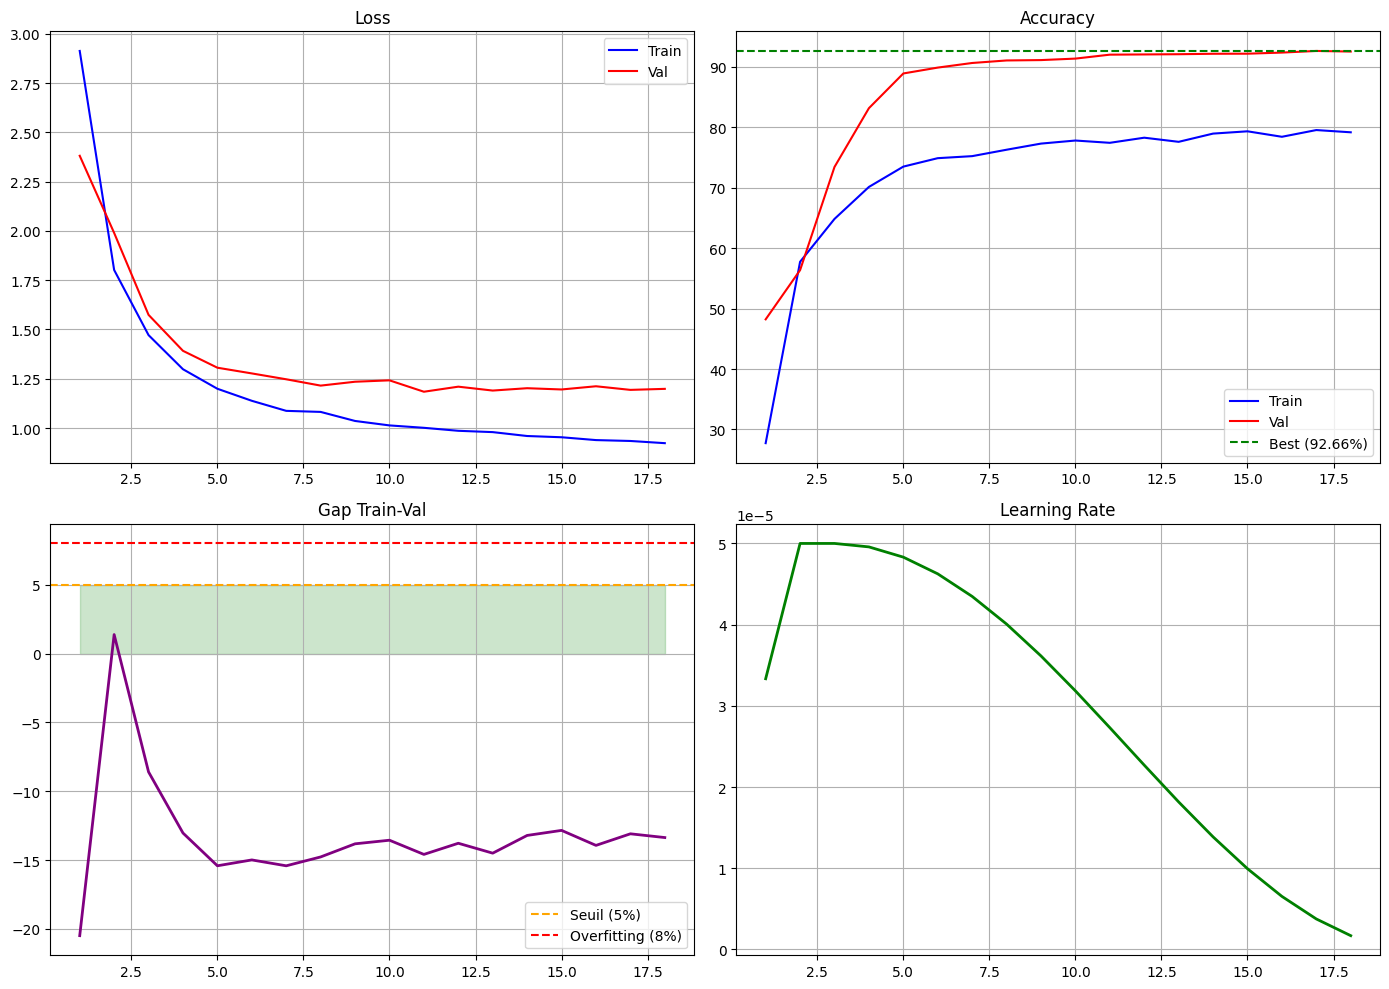

In [16]:
# ================== Visualisation ==================
epochs_trained = range(1, len(history['train_loss']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(epochs_trained, history['train_loss'], 'b-', label='Train')
axes[0, 0].plot(epochs_trained, history['val_loss'], 'r-', label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(epochs_trained, history['train_acc'], 'b-', label='Train')
axes[0, 1].plot(epochs_trained, history['val_acc'], 'r-', label='Val')
axes[0, 1].axhline(y=best_val_acc, color='g', linestyle='--', label=f'Best ({best_val_acc:.2f}%)')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Gap (indicateur overfitting)
axes[1, 0].plot(epochs_trained, history['gap'], 'purple', linewidth=2)
axes[1, 0].axhline(y=5, color='orange', linestyle='--', label='Seuil (5%)')
axes[1, 0].axhline(y=8, color='red', linestyle='--', label='Overfitting (8%)')
axes[1, 0].fill_between(epochs_trained, 0, 5, alpha=0.2, color='green')
axes[1, 0].set_title('Gap Train-Val')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning Rate
axes[1, 1].plot(epochs_trained, history['lr'], 'green', linewidth=2)
axes[1, 1].set_title('Learning Rate')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()


🧪 Évaluation sur test set...


C:\Users\ENNHILI YASSINE\AppData\Local\Temp\ipykernel_19788\1867516120.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_final.pth', ma

Test - Loss: 1.1891 | Acc: 92.49% | F1: 87.06%


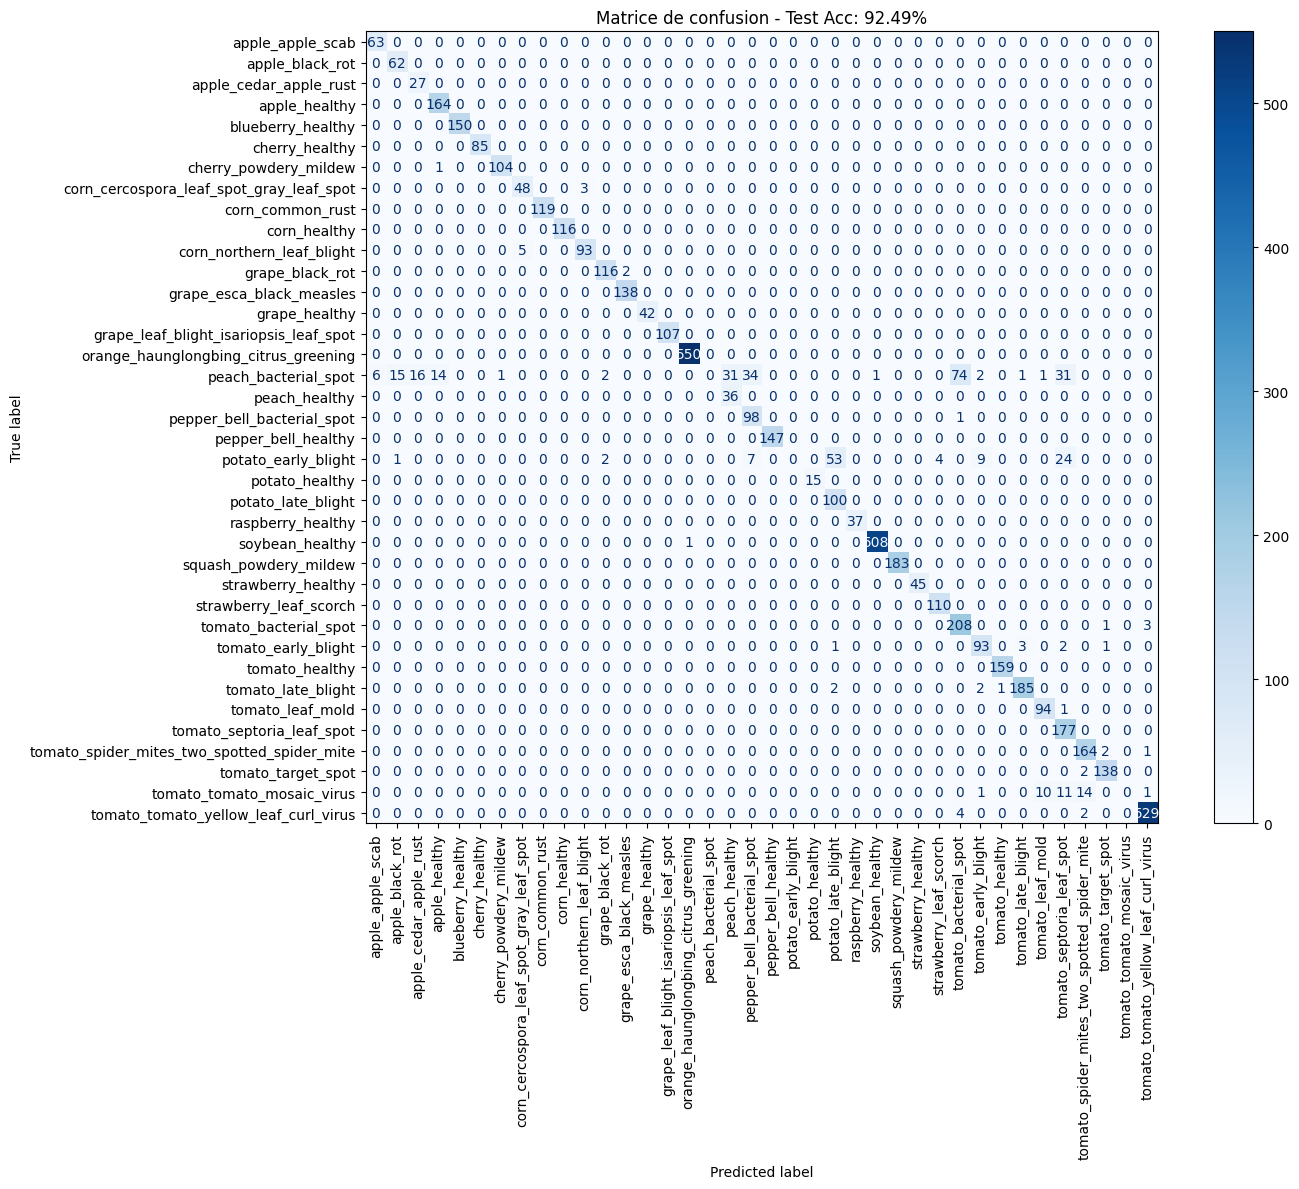

In [17]:
# ================== Test Set ==================
print("\n🧪 Évaluation sur test set...")
checkpoint = torch.load('best_model_final.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"Test - Loss: {test_loss:.4f} | Acc: {test_acc:.2f}% | F1: {test_f1:.2f}%")

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(15, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title(f"Matrice de confusion - Test Acc: {test_acc:.2f}%")
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [18]:
# ================== Grad-CAM ==================
class GradCAMVisualizer:
    def __init__(self, model):
        self.model = model
        self.gradients = {}
        self.activations = {}
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def save_gradient(name):
            def hook(module, grad_input, grad_output):
                self.gradients[name] = grad_output[0].detach()
            return hook

        def save_activation(name):
            def hook(module, input, output):
                self.activations[name] = output.detach()
            return hook

        vit_layer = self.model.vit.encoder.layers[-1]
        self.hooks.append(vit_layer.register_forward_hook(save_activation('vit')))
        self.hooks.append(vit_layer.register_backward_hook(save_gradient('vit')))

    def generate_cam(self, input_global, input_patches, target_class=None):
        self.model.eval()
        logits, attn_weights = self.model(input_global, input_patches)

        if target_class is None:
            target_class = logits.argmax(dim=1)

        self.model.zero_grad()
        class_score = logits[0, target_class]
        class_score.backward()

        cam_global = None
        if 'vit' in self.gradients and 'vit' in self.activations:
            gradients_vit = self.gradients['vit']
            activations_vit = self.activations['vit']

            if len(activations_vit.shape) == 3:
                activations_vit = activations_vit[:, 1:, :]
                gradients_vit = gradients_vit[:, 1:, :]

            weights = gradients_vit.mean(dim=1)
            cam_global = torch.einsum('bd,bnd->bn', weights, activations_vit)[0]
            cam_global = F.relu(cam_global)

            size = int(np.sqrt(cam_global.shape[0]))
            cam_global = cam_global.view(size, size)
            cam_global = cam_global / (cam_global.max() + 1e-8)
            cam_global = cam_global.cpu().numpy()

        return cam_global, logits, attn_weights

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()


def visualize_prediction(model, image_global, patches_local, label, class_names, device='cpu'):
    """Visualiser une prédiction avec Grad-CAM et attention"""
    img_global = image_global.unsqueeze(0).to(device)
    patches = patches_local.unsqueeze(0).to(device)

    grad_cam = GradCAMVisualizer(model)
    cam_global, logits, attn_weights = grad_cam.generate_cam(img_global, patches, target_class=None)

    pred_class = logits.argmax(dim=1).item()
    confidence = F.softmax(logits, dim=1)[0, pred_class].item()

    # Dénormaliser
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = image_global * std + mean
    img_display = img_display.permute(1, 2, 0).cpu().numpy()
    img_display = np.clip(img_display, 0, 1)

    # Visualisation
    num_patches = patches_local.shape[0]
    fig = plt.figure(figsize=(18, 8))

    # Image originale
    ax1 = plt.subplot(2, max(4, num_patches), 1)
    ax1.imshow(img_display)
    ax1.set_title(f'Original\nVrai: {class_names[label]}', fontsize=9)
    ax1.axis('off')

    # Grad-CAM Global
    ax2 = plt.subplot(2, max(4, num_patches), 2)
    ax2.imshow(img_display)
    if cam_global is not None:
        cam_resized = cv2.resize(cam_global, (224, 224))
        ax2.imshow(cam_resized, cmap='jet', alpha=0.5)
    ax2.set_title(f'Grad-CAM Global', fontsize=9)
    ax2.axis('off')

    # Info prédiction
    ax3 = plt.subplot(2, max(4, num_patches), 3)
    info_text = f'Prédiction: {class_names[pred_class]}\n'
    info_text += f'Confiance: {confidence:.1%}\n\n'
    if attn_weights is not None:
        info_text += f'Attention:\n'
        info_text += f'  Global: {attn_weights[0, 0].item():.3f}\n'
        info_text += f'  Local: {attn_weights[0, 1].item():.3f}'
    ax3.text(0.5, 0.5, info_text, ha='center', va='center', fontsize=9)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

    # Patches
    for i in range(num_patches):
        ax = plt.subplot(2, max(4, num_patches), max(4, num_patches) + 1 + i)
        patch_img = patches_local[i] * std + mean
        patch_img = patch_img.permute(1, 2, 0).cpu().numpy()
        patch_img = np.clip(patch_img, 0, 1)
        ax.imshow(patch_img)

        if hasattr(model, 'patch_attention_weights') and model.patch_attention_weights is not None:
            patch_attn = model.patch_attention_weights[0, i].item()
            ax.set_title(f'Patch {i+1}\nAttn: {patch_attn:.3f}', fontsize=8)
        else:
            ax.set_title(f'Patch {i+1}', fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'gradcam_prediction_{pred_class}.png', dpi=150, bbox_inches='tight')
    plt.show()

    grad_cam.remove_hooks()
    return pred_class, confidence


📊 Visualisation avec Grad-CAM sur quelques échantillons...

--- Échantillon 1/5 ---


C:\Users\ENNHILI YASSINE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


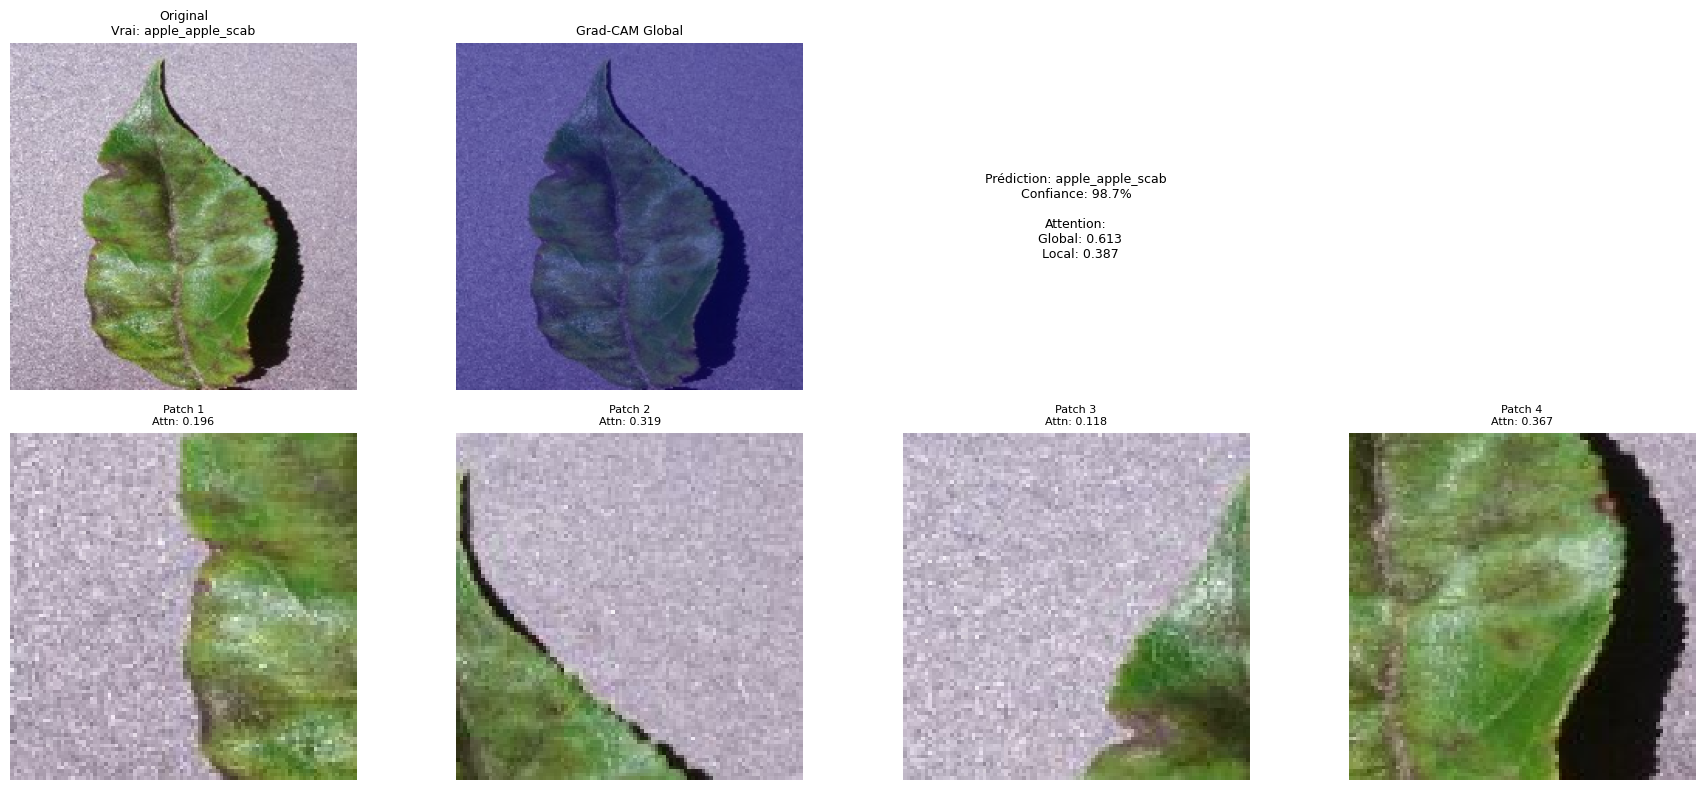

Vrai: apple_apple_scab, Prédit: apple_apple_scab (98.7%)

--- Échantillon 2/5 ---


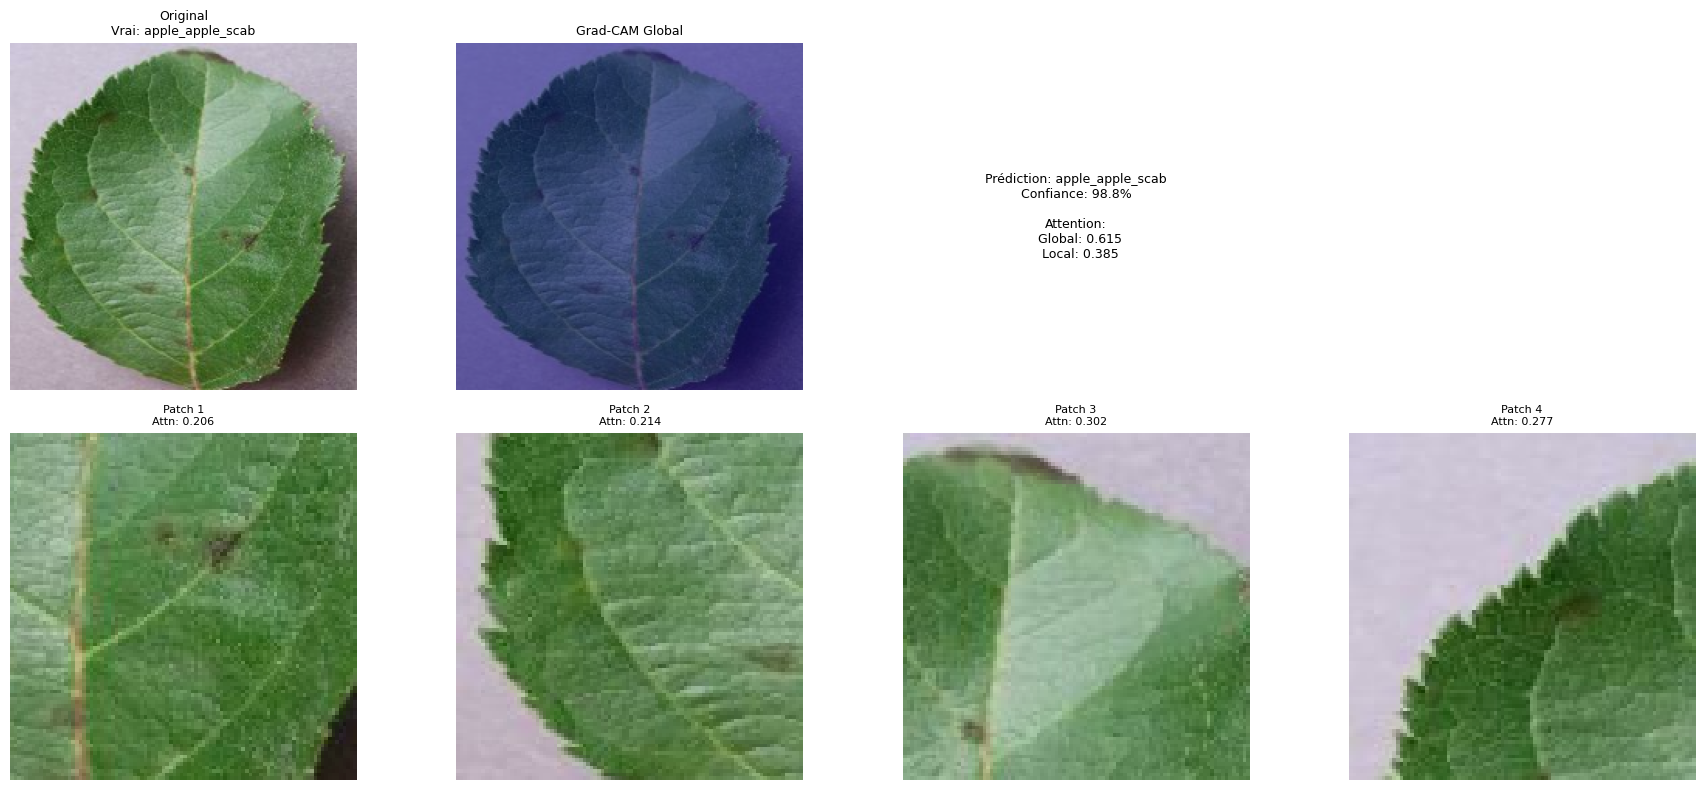

Vrai: apple_apple_scab, Prédit: apple_apple_scab (98.8%)

--- Échantillon 3/5 ---


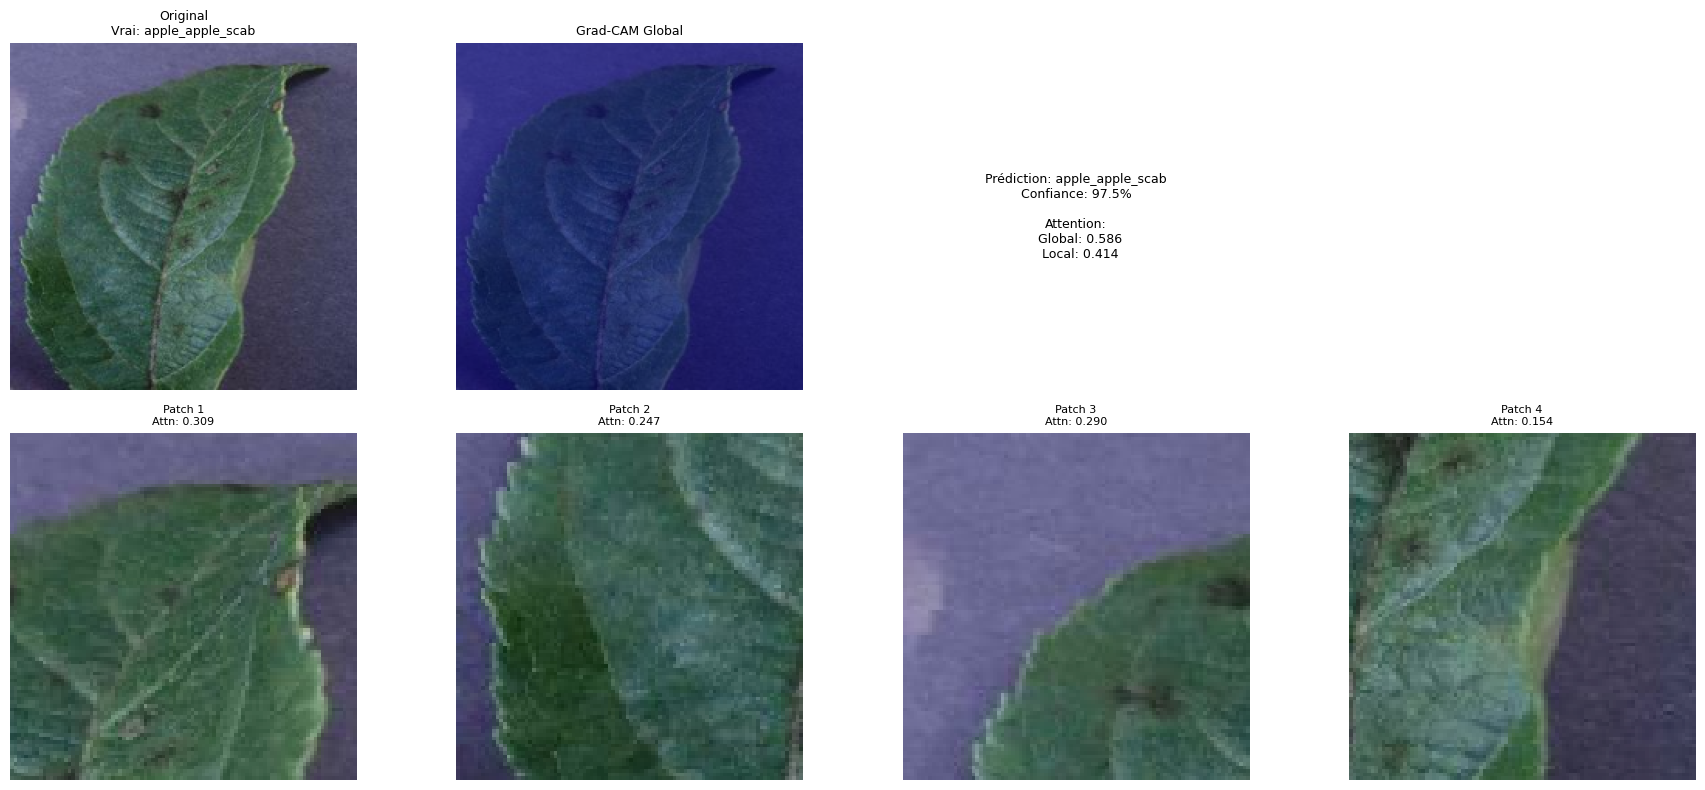

Vrai: apple_apple_scab, Prédit: apple_apple_scab (97.5%)

--- Échantillon 4/5 ---


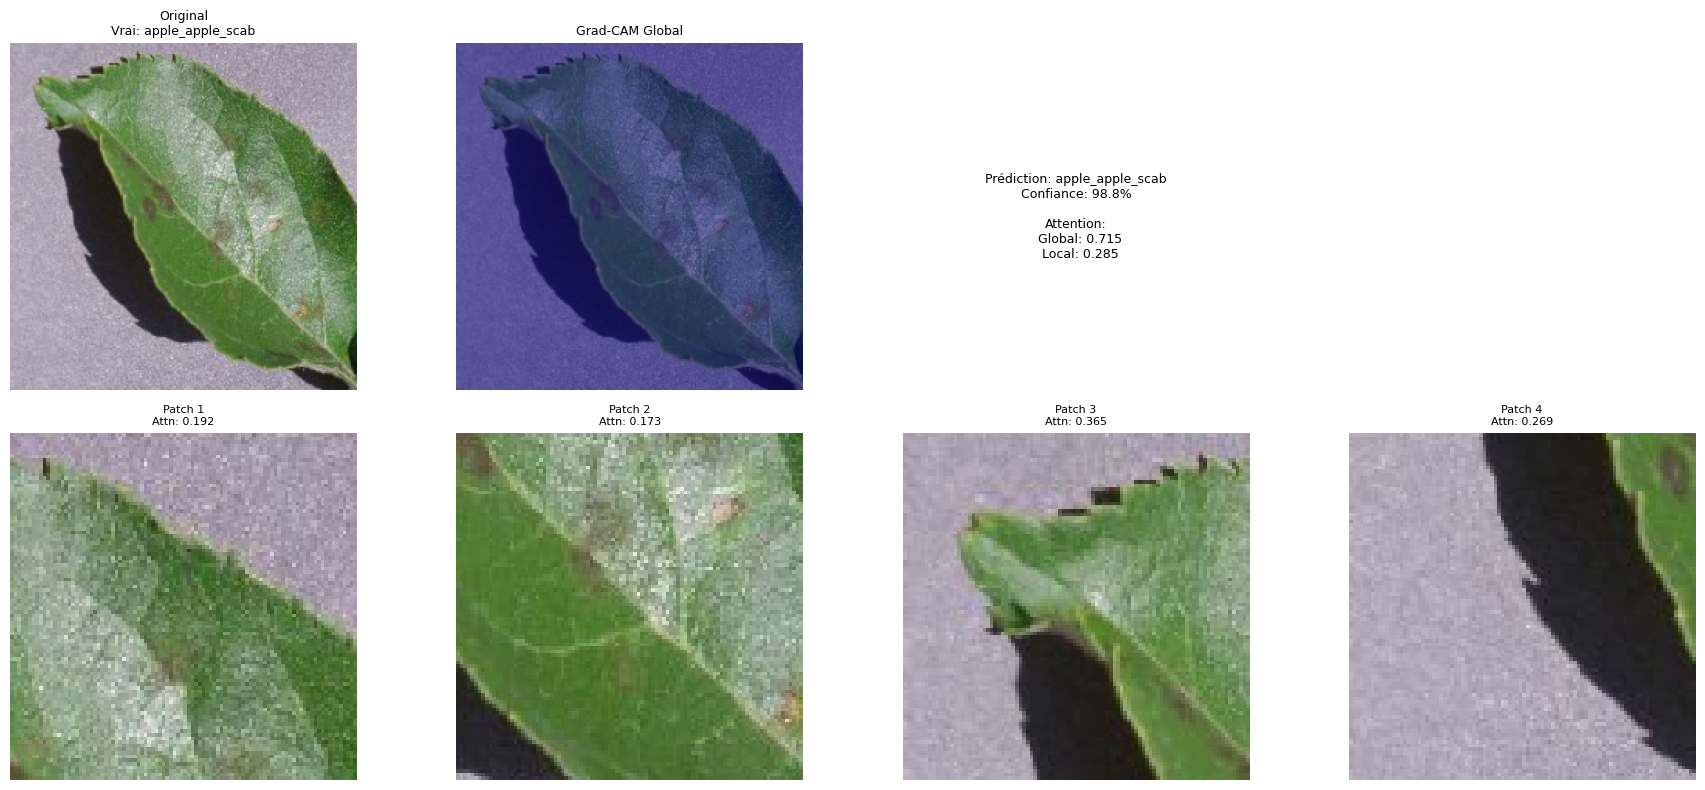

Vrai: apple_apple_scab, Prédit: apple_apple_scab (98.8%)

--- Échantillon 5/5 ---


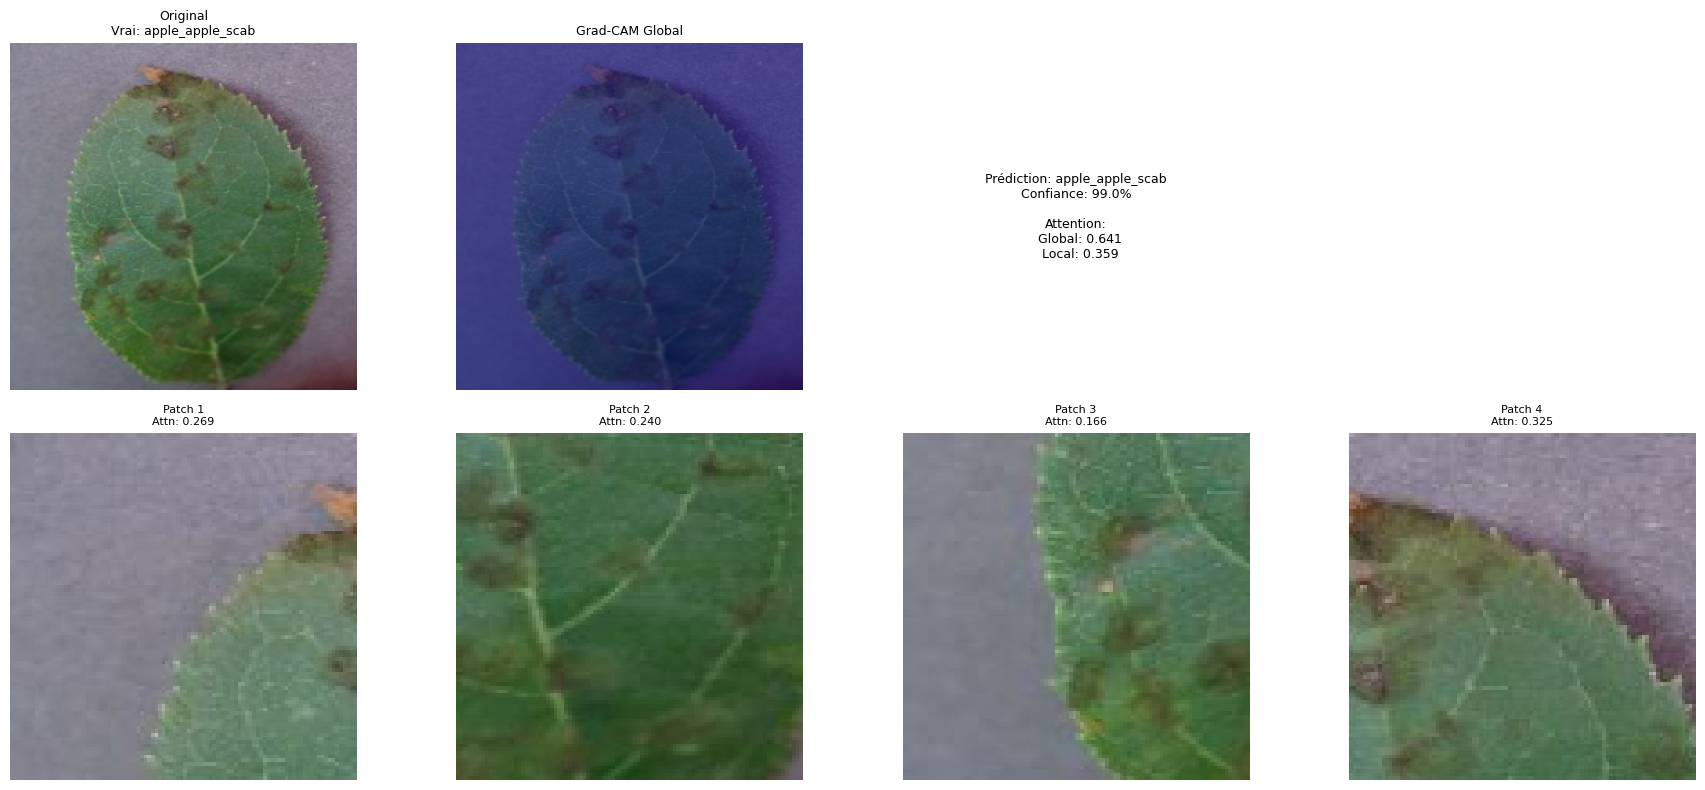

Vrai: apple_apple_scab, Prédit: apple_apple_scab (99.0%)


In [19]:
# ================== Tester Grad-CAM ==================
print("\n📊 Visualisation avec Grad-CAM sur quelques échantillons...")

model.eval()
samples_to_visualize = 5
count = 0

for img_g, patches_l, labels in test_loader:
    for i in range(len(labels)):
        if count >= samples_to_visualize:
            break

        print(f"\n--- Échantillon {count + 1}/{samples_to_visualize} ---")
        pred, conf = visualize_prediction(
            model,
            img_g[i],
            patches_l[i],
            labels[i].item(),
            class_names,
            device
        )
        print(f"Vrai: {class_names[labels[i]]}, Prédit: {class_names[pred]} ({conf:.1%})")

        count += 1

    if count >= samples_to_visualize:
        break